<a href="https://colab.research.google.com/github/kirmel4/MelSpectrogrammClassificationCNN/blob/main/MelSpectrogramClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Применение Мел-Спектрограммы в задаче аккустической классификации звуков.
Исследование проводилось на примере датасета ESC-50. Из него были выбраны классы, относящиеся к звукам различных животных.

In [24]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import librosa
import cv2
import numpy as np
import math
import random
import os
import pathlib
import requests
import shutil
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize
import torchvision.transforms as transforms
from librosa.util import buf_to_float
from librosa.display import waveshow, specshow
from librosa import amplitude_to_db, stft, power_to_db
from torch import nn
from torchsummary import summary
from librosa.core import fft_frequencies
from librosa.filters import mel
from sklearn.preprocessing import MinMaxScaler
!pip install torchmetrics
from torchmetrics import Accuracy
from functools import reduce 
SAMPLE_RATE = 22050
FFT = 1024#512
HOP = 512   #256
MELS = 16
DURATION = 5 #in seconds

ANNOTATIONS_FILE = "/content/ESC-50/meta/esc50_10labels.csv"
AUDIO_DIR = "/content/ESC-50/audio"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загрузка аннотации к датасету с последующим отбором необходимых для задачи данных. (human & non-speech sounds относятся к 20-29 классам включительно)

In [2]:
!git clone 'https://github.com/karolpiczak/ESC-50.git'

Cloning into 'ESC-50'...
remote: Enumerating objects: 4193, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4193 (delta 36), reused 28 (delta 12), pack-reused 4136
Receiving objects: 100% (4193/4193), 878.79 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (283/283), done.
Updating files: 100% (2011/2011), done.


In [3]:
metadata = pd.read_csv('/content/ESC-50/meta/esc50.csv')
metadata.drop(metadata[metadata['target'] > 9].index, inplace = True)
metadata.to_csv(path_or_buf = '/content/ESC-50/meta/esc50_10labels.csv')

In [ ]:
metadata.shape

(400, 7)

#Аугментация и препроцессинг
Мы не будем подавать на вход модели отдельно оригинальные аудиофайлы и аугментированные, так как, увеличивая количество эпох, наша модель в любом случае хотя бы раз увидит неаугментированные файлы, к тому же, будет лучше, если будет большое разнообразие одних и тех же звуков. Конечно, аугментированные данные никогда не будут лучше новых данных, но в данной задаче мы ограничены размером датасета




#Виды аугментации:

1.   изменение частоты звука
2.   изменение громкости звука
3.   добавление белого шума (из нормального распределения)
4.   изменение скорости звука


In [4]:
def get_sample(path, resample=SAMPLE_RATE):
  effects = [
      ['gain', '-n'], ["remix", "1"],
    ['rate', f'{resample}']
    ]
  waveform, sample_rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
  return waveform, sample_rate  

Реализация кастомного датасета на основе ESC-50

In [5]:
class ESC_50(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation,
                 target_sample_rate, num_samples):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = get_sample(audio_sample_path)
        if self.annotations.iloc[index]['if_train'] == 2:
          signal = self._pitch_scale_(signal, sr = sr)
          signal = self._random_gain_(signal)
          signal = self._add_white_noise_(signal.numpy())
          signal = self._time_stretching_(signal.numpy())
          signal =  self._cut_if_necessary_(signal)
          signal = self._right_pad_if_necessary_(signal)
        signal =  self._cut_if_necessary_(signal)
        signal = self.transformation(signal)
        return signal, label

    def _random_gain_(self, signal, min_factor=0.1, max_factor=0.12):
      gain_rate = random.uniform(min_factor, max_factor)
      augmented_signal = signal * gain_rate
      return augmented_signal

    def _time_stretching_(self, signal):
      r = round(random.uniform(0.8,1.25),2)
      return librosa.effects.time_stretch(signal, rate = r)
    def _cut_if_necessary_(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return torch.Tensor(signal)

    def _right_pad_if_necessary_(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return torch.Tensor(signal)

    def _pitch_scale_(self,  signal, sr):
      num_semitones = random.randint(-2,2)
      return torch.Tensor(librosa.effects.pitch_shift(signal.numpy(), sr = sr, n_steps = num_semitones))

    def _add_white_noise_(self, signal):
      noise = np.random.normal(0, signal.std(), signal.size)
      noise_percentage_factor = round(random.uniform(0.01, 0.15), 2)
      augmented_signal = signal + noise * noise_percentage_factor
      return torch.Tensor(augmented_signal)

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]

In [6]:
import numpy as np
size = len(metadata) 
arr = np.zeros(size) 

ones_idx = np.random.choice(size, int(size*0.15), replace=False)
twos_idx = np.random.choice(np.setdiff1d(np.arange(size), ones_idx), int(size*0.8), replace=False)
arr[ones_idx] = 1
arr[twos_idx] = 2

Берём преобразование в спектрограмму из класса MelSpectrogram

In [7]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=FFT,
        hop_length=HOP,
        n_mels=MELS
    )

Инициализируем наш датасет и делим его на тренировочную, валидационную и тестовую выборки. Для этого мы создадим столбец, в котром будет 80% двоек (флаг тренировочной выборки), 10% единиц (валидация) и 10% нулей (тест). Аугментировать из них мы, конечно же, будем только тренировочную выборку, потому что на валидации мы хотим видеть качество работы модели на обычных, неискажённых данных

In [8]:
train_dataset = ESC_50(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                            SAMPLE_RATE, DURATION * SAMPLE_RATE)
train_dataset.annotations = train_dataset.annotations.iloc[:, 1:7]
train_dataset.annotations.iloc[:, 2] = train_dataset.annotations.iloc[:, 2] #- 20
train_dataset.annotations['if_train'] = arr
train_dataset.annotations = train_dataset.annotations[train_dataset.annotations['if_train'] == 2]

val_dataset = ESC_50(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                            SAMPLE_RATE, DURATION * SAMPLE_RATE)
val_dataset.annotations = val_dataset.annotations.iloc[:, 1:7]
val_dataset.annotations.iloc[:, 2] = val_dataset.annotations.iloc[:, 2] #- 20
val_dataset.annotations['if_train'] = arr
val_dataset.annotations = val_dataset.annotations[val_dataset.annotations['if_train'] == 1]

test_dataset = ESC_50(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                            SAMPLE_RATE, DURATION * SAMPLE_RATE)
test_dataset.annotations = test_dataset.annotations.iloc[:, 1:7]
test_dataset.annotations.iloc[:, 2] = test_dataset.annotations.iloc[:, 2] #- 20
test_dataset.annotations['if_train'] = arr
test_dataset.annotations = test_dataset.annotations[test_dataset.annotations['if_train'] == 0]

In [ ]:
len(train_dataset)

320

Функции для демонстрации осциллограммы и спектрограммы аудиофайлов

In [9]:
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

Функция для воспроизведения аудиофайлов

In [10]:
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

Пример аугментации аудиофайла

In [11]:
example = '/content/ESC-50/audio/1-100032-A-0.wav'
signal_, sample_rate_ = get_sample(example, resample = SAMPLE_RATE)

In [12]:
augmented_signal = train_dataset._random_gain_(signal_)
augmented_signal = train_dataset._pitch_scale_(augmented_signal, sample_rate_)
augmented_signal = train_dataset._add_white_noise_(augmented_signal.numpy())
augmented_signal = train_dataset._cut_if_necessary_(augmented_signal.numpy())

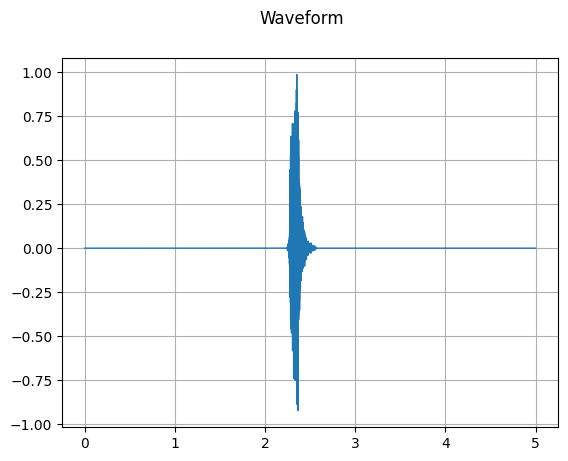

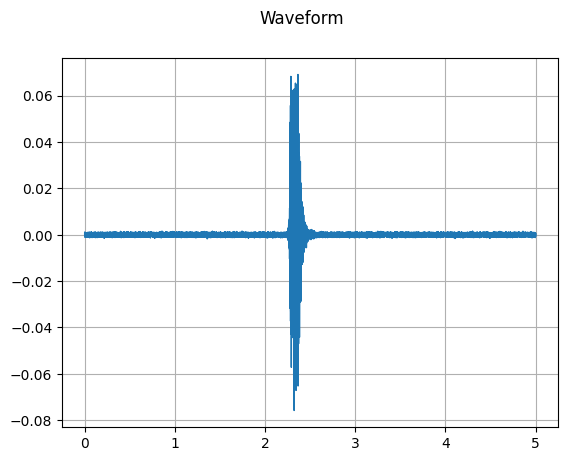

In [13]:
plot_waveform(signal_, sample_rate_)
play_audio(signal_, sample_rate_)
plot_waveform(augmented_signal, sample_rate_)
play_audio(augmented_signal, sample_rate_)

Хочется отметить что рандомное увеличение звука для аудио сложно продемонстрировать на примере и оно может быть не сильно заметно для человека, что нельзя сказать про модель

В связи с тем, что человеческое ухо более чувствительно к изменениям низких частот, было введено понятие *мел*. Так как мы хотим приблизить предсказания модели к человеческим, то и данные нужно подавать такими, какими их слышит человек.
Фильтры, размещенные на частотной шкале, в свою очередь скалярно умножаются на каждый столбец исходной спектрограммы , после чего получается вектор чисел, по размеру равный количеству фильтров. 
А так же такое преобразование уменьшает размерность пространства признаков, следвательно, уменьшает количество обучаемых параметров для нейронной сети.

Выбор 16 мел-фильтров был обусловлен тем, что у нас не такие сложные данные и нам не совсем важно тонко чувствовать грань между разными частотами, как например в классификации музыкальных инструментов или спикера

Визуализация линейного размещения мел-фильтров на частотной оси и мел-оси

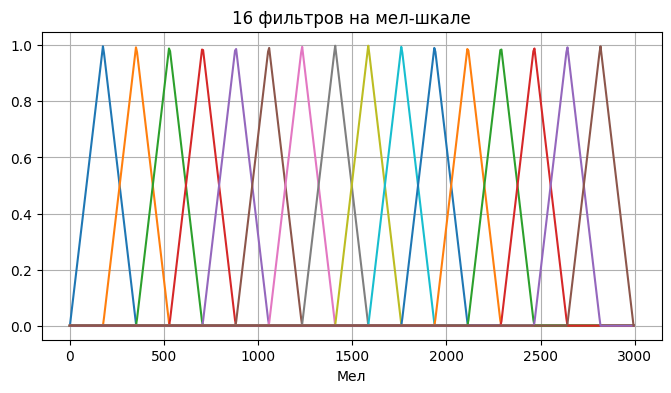

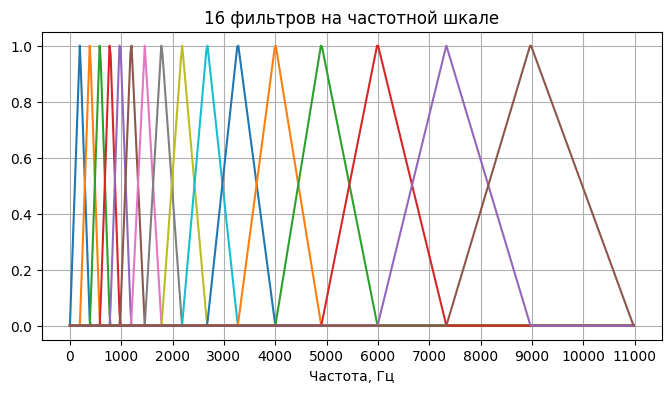

In [14]:
# код был взят отсюда (https://librosa.github.io/librosa/_modules/librosa/filters.html#mel)
def freq_to_mel(f):
    return 1127.0 * np.log(1.0 + f / 700.0)
n_mels_demo = MELS
max_mel = freq_to_mel(SAMPLE_RATE//2)
mel_f = np.linspace(0, SAMPLE_RATE//2, n_mels_demo + 2)

weights_ = np.zeros((n_mels_demo, int(1 + FFT // 2)))

fftfreqs = fft_frequencies(sr=SAMPLE_RATE, n_fft=FFT)
fdiff = np.diff(mel_f)
ramps = np.subtract.outer(mel_f, fftfreqs)

for i in range(n_mels_demo):
    # lower and upper slopes for all bins
    lower = -ramps[i] / fdiff[i]
    upper = ramps[i+2] / fdiff[i+1]

    # .. then intersect them with each other and zero
    weights_[i] = np.maximum(0, np.minimum(lower, upper))

# Рисуем полученные фильтры на мел шкале
plt.figure(figsize=(8, 4))
plt.title('{} фильтров на мел-шкале'.format(n_mels_demo))
for f in weights_:
    plt.plot(f)
plt.xlabel('Мел')
plt.grid()
freq_labels_ = [freq for freq in range(0, int(max_mel), 500)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

# Рисуем полученные фильтры на частотной шкале
mel_matrix = mel(sr=SAMPLE_RATE, n_fft=FFT, n_mels=MELS)
# делаем фильтры "высотой" единица
mel_matrix = MinMaxScaler().fit_transform(mel_matrix.T).T

plt.figure(figsize=(8, 4))
plt.title('{} фильтров на частотной шкале'.format(n_mels_demo))
for f in mel_matrix:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels_ = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

In [15]:
def show_spec(f_name):
    wav_data, sr = get_sample(f_name)
    spec = train_dataset._random_gain_(wav_data)
    spec = train_dataset._pitch_scale_(spec, SAMPLE_RATE)
    spec = train_dataset._add_white_noise_(spec.numpy())
    spec = train_dataset._cut_if_necessary_(spec.numpy())
    spec = stft(spec.numpy(), n_fft=FFT, hop_length = HOP)
    spec_db = amplitude_to_db(abs(spec))
    return spec_db.squeeze(0)
spec_ = show_spec(example)

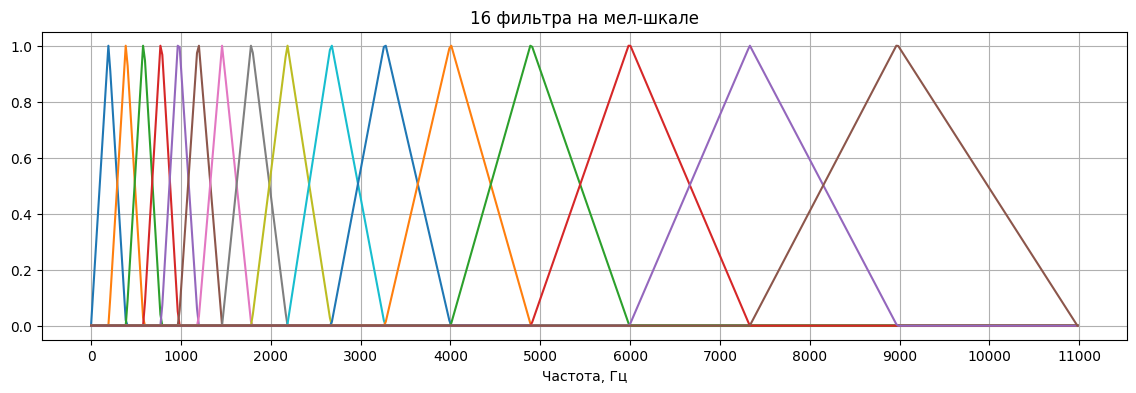

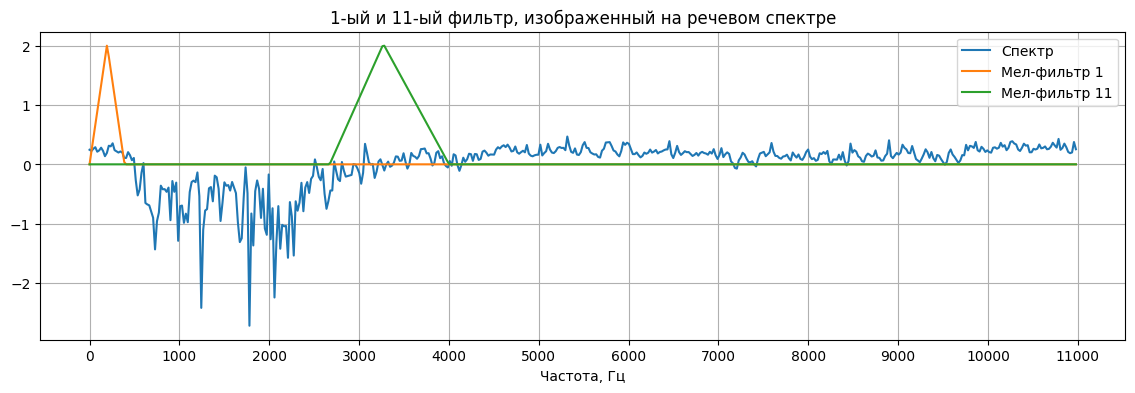

In [16]:
mel_matrix_ = mel(sr=SAMPLE_RATE, n_fft=FFT, n_mels=MELS)
mel_matrix__ = MinMaxScaler().fit_transform(mel_matrix.T).T

# Рисуем полученные фильтры на частотной шкале
plt.figure(figsize=(14, 4))
plt.title('{} фильтра на мел-шкале'.format(MELS))
for f in mel_matrix__:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

# отдельный фильтр вместе со спектром
first_filter = mel_matrix__[0]
eleventh_filter = mel_matrix__[10]
spec_part = np.log10(np.abs(spec_[:, 100]))
spec_part -= spec_part.mean()

plt.figure(figsize=(14, 4))
plt.plot(spec_part, label='Спектр')
plt.title('1-ый и 11-ый фильтр, изображенный на речевом спектре')
plt.plot(first_filter*2, label='Мел-фильтр 1')
plt.plot(eleventh_filter*2, label='Мел-фильтр 11')
plt.legend()
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels_ = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)

plt.show()

In [17]:
print('Форма матрицы фильтров:', mel_matrix.shape)
print('Форма спектрограммы:', spec_.shape)

mel_spec_ = np.dot(mel_matrix_, spec_) #матричное произведение

print('Форма мел-спектрограммы:', mel_spec_.shape)

Форма матрицы фильтров: (16, 513)
Форма спектрограммы: (513, 216)
Форма мел-спектрограммы: (16, 216)


Как мы можем заметить, такое преобразование убрало "лишнюю" информацию и оставило "суть" данных. 

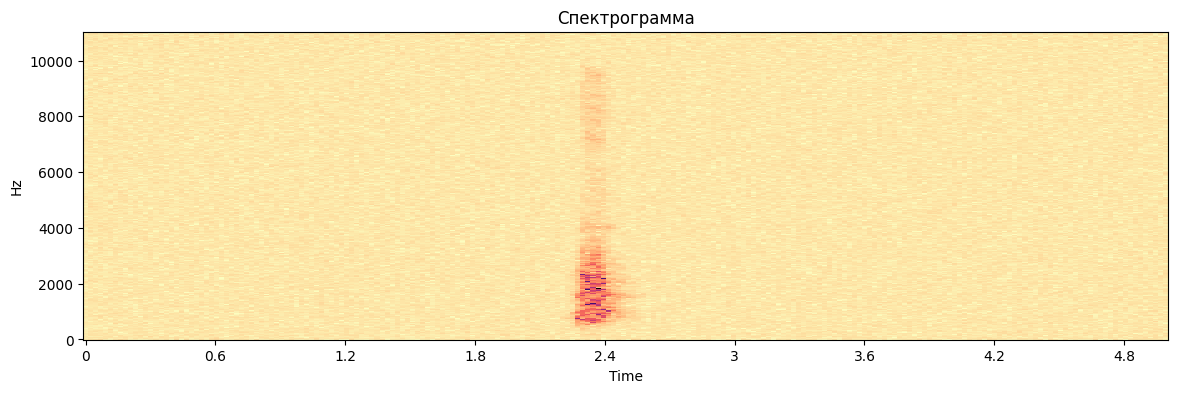

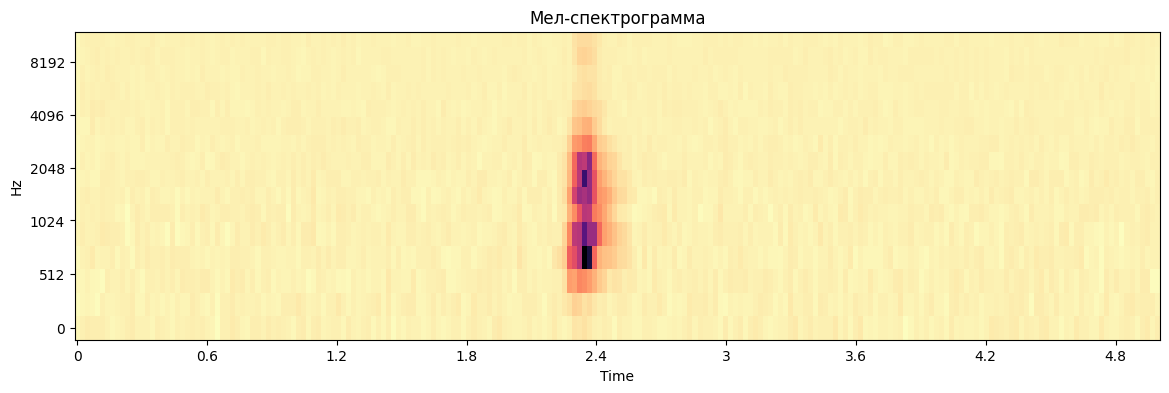

In [18]:
spec_db = amplitude_to_db(abs(spec_))
plt.figure(figsize=(14, 4))
specshow(spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='hz')
plt.title('Спектрограмма')
plt.show()

mel_spec_db = amplitude_to_db(abs(mel_spec_))
plt.figure(figsize=(14, 4))
plt.title('Мел-спектрограмма')
specshow(mel_spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.show()

#Cвёрточная нейронная сеть

Рассмотрим Свёрточную нейронную сеть, так как именно этот вид сетей показывает наилучшие результаты в области распознавания изображений
Собственно для этого мы и делали такие преобразования сначала в спектрограмму, а затем в мел-спектрограмму. Важной особенностью
свёрточных нейронных сетей является устойчивость к изменениям масштаба и смещениям
изображения, что, очевидно, имеет место в случае спектрограмм речевых сигналов

Рассмотрим архитектуру нейронной сети:

1) Сверточные слои, выделяющие из черно-белой картинки сначала 16 признаков, затем из 16 - > 64 с ядрами 3x3 и  функцией активации ReLU 

2) Слой преобразования массива в вектор

3)Полносвязный слой активационная функция «сигмоида»



In [19]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
              nn.Conv2d(1, 16, 3, stride = 2),
              nn.ReLU(),
              nn.Conv2d(16, 64, 3, stride = 2),
              nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(10176, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv(input_data)
        x = self.flatten(x)
        logits = self.linear1(x)
        predictions = self.softmax(logits)
        return predictions

In [20]:
cnn = CNNNetwork()
summary(cnn.cuda(), (1, 16,216))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 7, 107]             160
              ReLU-2           [-1, 16, 7, 107]               0
            Conv2d-3            [-1, 64, 3, 53]           9,280
              ReLU-4            [-1, 64, 3, 53]               0
           Flatten-5                [-1, 10176]               0
            Linear-6                   [-1, 10]         101,770
           Softmax-7                   [-1, 10]               0
Total params: 111,210
Trainable params: 111,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.42
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


In [25]:
BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 75
LEARNING_RATE = 0.002
accuracy = Accuracy(task="multiclass", num_classes=10)

Функция для тренировки и валидации и подсчётом accuracy

In [26]:
def train_epoch(model, device, dataloader, loss_fn, optimizer , metric):
    train_loss = []
    accuracy_pred = []
    accuracy_target = []
    for image_batch, target in dataloader: 
      
        image_batch, target = image_batch.cuda(), target.cuda()
        image_batch = image_batch.to(device)
        accuracy_target = accuracy_target + list(target)
        prediction = model(image_batch)
        _, predicted = prediction.max(1)
        accuracy_pred = accuracy_pred + list(predicted)
        loss = loss_fn(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss), metric(torch.Tensor(accuracy_pred), torch.Tensor(accuracy_target))

In [27]:
def test_epoch(model, device, dataloader, loss_fn, metric):
    val_accuracy_target = []
    val_accuracy_pred = []
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, target in dataloader:
            image_batch = image_batch.to(device)
            val_accuracy_target = val_accuracy_target + list(target)
            prediction = model(image_batch)
            conc_out.append(prediction.cpu())
            conc_label.append(target.cpu())
            _, predicted = prediction.max(1)
            val_accuracy_pred = val_accuracy_pred + list(predicted)
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data, accuracy(torch.Tensor(val_accuracy_pred), torch.Tensor(val_accuracy_target))

In [28]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")

Using cuda


In [29]:
cnn = CNNNetwork().to(device)
print(cnn)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=10176, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


Вводим функцию ошибки 

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

Инициализации даталоадеров для загрузки данных в нейросеть батчами

In [31]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

#Обучение

In [33]:
for epoch in range(EPOCHS):
   train_loss, train_accuracy =train_epoch(cnn,device,train_loader,loss_fn,optimiser, accuracy)
   val_loss, val_accuracy = test_epoch(cnn,device,val_loader,loss_fn, accuracy)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {} \n train accuracy {} \t val accuracy {}'.format(epoch + 1, EPOCHS,train_loss, val_loss, train_accuracy, val_accuracy))


 EPOCH 1/75 	 train loss 2.251344919204712 	 val loss 2.1778080463409424 
 train accuracy 0.18125000596046448 	 val accuracy 0.28333333134651184

 EPOCH 2/75 	 train loss 2.0256409645080566 	 val loss 2.1111505031585693 
 train accuracy 0.48750001192092896 	 val accuracy 0.3499999940395355

 EPOCH 3/75 	 train loss 1.93521249294281 	 val loss 2.044480562210083 
 train accuracy 0.565625011920929 	 val accuracy 0.4166666567325592

 EPOCH 4/75 	 train loss 1.9219127893447876 	 val loss 2.061150550842285 
 train accuracy 0.546875 	 val accuracy 0.4000000059604645

 EPOCH 5/75 	 train loss 1.8920753002166748 	 val loss 2.011150598526001 
 train accuracy 0.5718749761581421 	 val accuracy 0.44999998807907104

 EPOCH 6/75 	 train loss 1.8658301830291748 	 val loss 1.9546582698822021 
 train accuracy 0.6000000238418579 	 val accuracy 0.5

 EPOCH 7/75 	 train loss 1.824811339378357 	 val loss 1.9111486673355103 
 train accuracy 0.6499999761581421 	 val accuracy 0.550000011920929

 EPOCH 8/75 	 

#Оценка модели

In [34]:
# сохраняем модель
torch.save(cnn.state_dict(), "CNNforESC_50.pth")
print("Trained CNNforESC_50 saved at CNNforESC_50.pth")

Trained CNNforESC_50 saved at CNNforESC_50.pth


In [35]:
def evaluate(model, test_dataloader, criterion): 
  model.eval() 
  total_loss = 0 
  correct = 0
  model = model.to('cuda')
  with torch.no_grad():     
    for data, target in test_loader:
      if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()         
      output = model(data)        
      total_loss += criterion(output, target).item()         
      pred = output.argmax(dim=1, keepdim=True)         
      correct += pred.eq(target.view_as(pred)).sum().item()  
    avg_loss = total_loss / len(test_loader.dataset) 
    accuracy = 100. * correct / len(test_loader.dataset)  
  print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [36]:
evaluate(cnn, test_loader, loss_fn)

Test set: Average loss: 0.2692, Accuracy: 14/20 (70.00%)


На валидации получили максимальную точность **63**. А на тестовой выборке - **70**

Прирост метрики дало уменьшение частоты дискретизации, применение аугментации и увеличение количества эпох. А самый большой прирост дало уменьшение мел-фильтров.

Предполагаю, что результаты можно улучшить, используя мел кепстральные коэффициенты и взять больше данных, увеличить количество эпох

In [45]:
class_mapping = [
    "Dog",
    "Rooster",
    "Pig",
    "Cow",
    "Frog",
    "Cat",
    "Hen",
    "Insects ",
    "Sheep",
    "Crow"
]

In [46]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        input = input.cuda()
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


In [47]:
from random import randint
r = randint(0,len(test_dataset)-1)   
input, target = test_dataset[r][0], test_dataset[r][1]
input.unsqueeze_(0)

    # make an inference
predicted, expected = predict(cnn, input, target,
                                  class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'Sheep', expected: 'Sheep'
